In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import *
from scipy.optimize import curve_fit


From Wikipedia, the Bethe-Bloch formula is given by 
$$- \left\langle\frac{dE}{dx}\right\rangle = \frac{4 \pi}{m_e c^2} \frac{nz^2}{\beta^2}\left(\frac{e^2}{4\pi\varepsilon_0}\right)^2 \left[\ln \left(\frac{2m_e c^2 \beta^2}{I  (1-\beta^2)}\right) - \beta^2\right]$$

where $n = \frac{N_AZ\rho}{A}$ and $I_{Cu}/Z_{Cu} = 11 eV$, $I_{C}/Z_{C} = 15 eV$.

In [2]:
def electronDensity(Z, rho, A):
    return N_A * Z * rho /(A*1.)

def betheBlochFormula(n, z, I, beta = 0.9998):
    toreturn = 4*np.pi/(m_e*c**2) * n*z**2 /(beta**2) * (e**2/(4*np.pi*epsilon_0))**2\
    * (np.log(2*m_e*c**2*beta**2/(I*(1-beta**2)))-beta**2)
    return -1*toreturn

In [3]:
copper_density = 8920. #kg/m3
plastic_density = 940. #kg/m3  Low/High density Polyethilene
copper_I = 11*29*e #Joules
plastic_I = 15*6*e #Joules
copper_elec_dens = electronDensity(29, copper_density, 63.54)
plastic_elec_dens = electronDensity(6, plastic_density, 12)

In [4]:
print 'For Cu', -betheBlochFormula(copper_elec_dens, 1, copper_I)/e *1e-6, 'MeV'
print 'For C (Plastic)', -betheBlochFormula(plastic_elec_dens, 1, plastic_I)/e *1e-6, 'MeV'

For Cu 1.86298756486643 MeV
For C (Plastic) 0.23334606184953993 MeV


# Compute $\lambda_1$

In [5]:
t1 = 2.4e3# mus
lambda1 = t1**-1
print lambda1
def Z4Law(Z):
    lambda_capture_z = lambda1*Z**4
    tau_capture_z = lambda_capture_z**-1
    return tau_capture_z
print Z4Law(29)
lifetimes_neg_matter = np.array([2.4e3, 25., 1.5, .22, .09])
Zs = np.array([1, 6, 13, 26, 82.])
rates_neg_matter = 1./lifetimes_neg_matter
print rates_neg_matter/(Zs**4)

0.000416666666667
0.00339327650538
[4.16666667e-04 3.08641975e-05 2.33418531e-05 9.94681240e-06
 2.45754841e-07]


# Initial calibration with unknown threshold

In [6]:
import pandas as pd
from scipy import stats
from scipy.optimize import fsolve


In [7]:
raw_data = pd.read_excel('Calib_PMT_2.xlsx')
display(raw_data)
def extract_data(r_data, PMT_num):
    PMT_data = r_data[r_data['PMT']==PMT_num]
    PMT_data = PMT_data.drop('PMT', axis=1)
    PMT_data = PMT_data.set_index(PMT_data['Voltage (kV)'])
    PMT_data = PMT_data.sort_values('Voltage (kV)')
    PMT_matrix = PMT_data.as_matrix()
    return PMT_matrix

,PMT,Voltage (kV),Counts (60s)
0,1,2.01,1814
1,2,2.00,535
2,2,2.05,1005
3,1,2.05,2550
4,1,2.10,5007
5,2,2.10,1957
6,1,2.15,7575
7,2,2.15,3108
8,1,2.20,12723
9,2,2.20,5202


In [8]:
matrices = [extract_data(raw_data, i) for i in range(1, 5)]

In [9]:
def line(x, m, b, des):
    return m*x + b - des

def get_calibrating_voltage(PMT_matrix, desired_count, pmt, marker='o', linestyle='-', color='r'):
    V_data = PMT_matrix[:,0]
    count_data = PMT_matrix[:,1]
    log_count_data = np.log(count_data)
    V_mask=[v<=2.3 and v>=2 for v in V_data]
    V_data = V_data[V_mask]
    log_count_data = log_count_data[V_mask]
    plt.plot(V_data, log_count_data, label = 'PMT %i'%pmt, marker=marker, markersize=8, lw=0, c=color)
    plt.xlabel('$V(kV)$', fontsize=15)
    plt.ylabel('$\ln N(a.u.)$', fontsize=15)
    slope, intercept, r_value, p_value, std_err = stats.linregress(V_data, log_count_data)
    plt.plot(np.linspace(2, 2.4, 100), slope*np.linspace(2, 2.4, 100)+intercept, ls = linestyle, c=color)
    #print slope, intercept
    plt.legend()
    return fsolve(line, 2, (slope, intercept, desired_count))
    

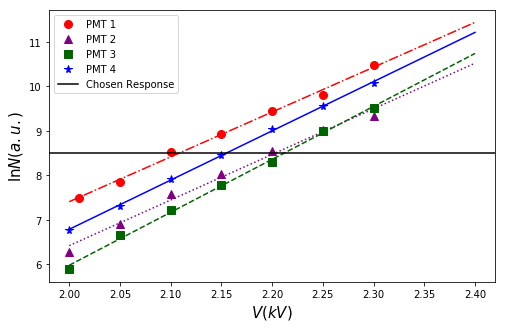

In [10]:
plt.figure(figsize=(8,5))
markers = ['o', '^', 's', '*']
linestyles = ['-.', ':', '--', '-']
colors = ['r', 'purple', 'darkgreen', 'b']
resV = [(i+1,get_calibrating_voltage(matrix, 8.5, i+1, marker=markers[i], linestyle=linestyles[i], color=colors[i])[0]) for i, matrix in enumerate(matrices)]
plt.axhline(8.5, c='k', label='Chosen Response')
plt.legend()
plt.gcf()
plt.savefig('PMTCalib.png', dpi=300)

In [11]:
for t in resV:
    print '%i & %.2f \\\\'%t

1 & 2.11 \\
2 & 2.20 \\
3 & 2.21 \\
4 & 2.15 \\


# Calibración Threshold

    Threshold (V)  Counts (10s) source  Counts (10s) no source
31           0.29                84670                   16311
30           1.07                53838                    8590
29           1.22                46825                    6775
28           1.43                39568                    5306
27           1.64                34844                    4272
26           1.83                32054                    3568
25           1.98                30379                    3238
24           2.11                28973                    3148
23           2.25                27921                    2838
22           2.38                26928                    2648
21           2.60                25892                    2624
20           2.70                25353                    2384
19           2.89                24518                    2173
18           3.03                24256                    2073
17           3.19                23269                 

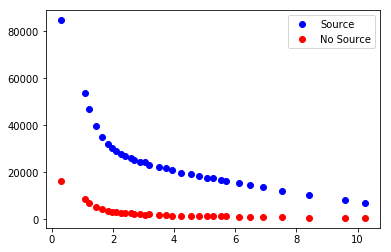

In [12]:
raw_data = pd.read_excel('Threshold_calib.xlsx')
raw_data= raw_data.sort_values('Threshold (V)')
mat = raw_data.as_matrix()
plt.plot(mat[:,0], mat[:,1], 'ob', label='Source')
plt.plot(mat[:,0], mat[:,2], 'or', label='No Source')
plt.legend(loc=0)
print raw_data

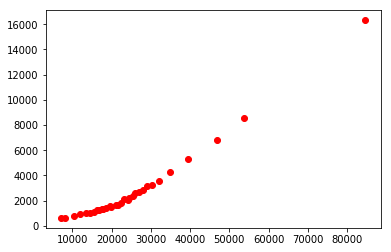

In [13]:
plt.plot(mat[:,1], mat[:,2], 'or', label='Source vs. No Source')

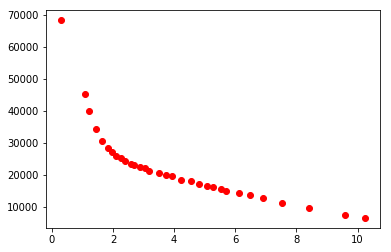

In [14]:
plt.plot(mat[:,0], mat[:,1]-mat[:,2], 'or', label='Source - No Source')


+ Compton scattering: Relation between incoming photon and electron energy
+ Muon decay products' energy
+ More precise threshold measurements


In [15]:
def electron_E(E_gamma):
    return E_gamma*(1-1./(1+2*(E_gamma/(511e-3))))

In [16]:
gamma_energies = [1.17, 1.33] #Cobalt
gamma_Co = [electron_E(E) for E in gamma_energies]
print 'Co', gamma_Co, 'MeV'

gamma_energies = [0.032, 0.662] #Cs
gamma_Cs = [electron_E(E) for E in gamma_energies]
print 'Cs', gamma_Cs, 'MeV'

Co [0.9602946334619431, 1.115673289183223] MeV
Cs [0.003561739130434784, 0.47765013623978203] MeV


# Cumulative Spectrum

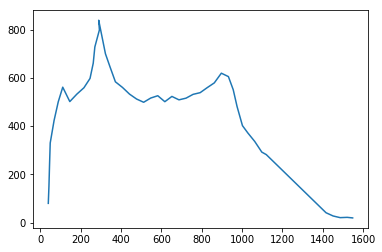

In [17]:
from scipy import interpolate
spectrum = np.loadtxt('Co_Spectrum.csv', delimiter =',')
def cumulate_spectrum(spectrum):
    evaluate_spectrum = interpolate.interp1d(spectrum[:,0], spectrum[:,1], kind='cubic')
    x = np.linspace(spectrum[:,0][0], spectrum[:,0][-1], 100)
plt.plot(spectrum[:,0], spectrum[:,1])

In [18]:
#This function can either print or store the markov chain. For parallel computing it is easier to print.
def MH_Spectrum_Sampling(spectrum, niter):
    evaluate_spectrum = interpolate.interp1d(spectrum[:,0], spectrum[:,1])
    markov_chain=[]
    max_interval=spectrum[:,0][-1]
    initial_value=max_interval*np.random.random()
    #print initial_value
    markov_chain.append(initial_value)
    for i in range(niter):
        std = 10**(np.log10(spectrum[:,0][-1]))
        to_try = np.random.normal(markov_chain[i], std)
        while(to_try<spectrum[:,0][0] or to_try>spectrum[:,0][-1]):
            to_try = np.random.normal(markov_chain[i], std)
        possible_jump=to_try
        criteria = evaluate_spectrum(possible_jump)/evaluate_spectrum(markov_chain[i])
        if(criteria>=1.):
            #print abs(possible_jump)
            markov_chain.append(abs(possible_jump))
        else:
            other_random = np.random.random()
            if(other_random<=criteria):
                #print possible_jump
                markov_chain.append(possible_jump)
            else:
                #print markov_chain[i]
                markov_chain.append(markov_chain[i])
    return np.array(markov_chain)

In [19]:
raw_data_Co = pd.read_excel('Threshold_calib.xlsx')

def decumulate_measured_spectrum(raw, kind):
    raw= raw.sort_values('Threshold (V)')
    #display(raw)
    mat = raw.as_matrix()
    measured_spectrum = np.column_stack((mat[:,0], (mat[:,1]-mat[:,2])))
    plt.scatter(measured_spectrum[:,0], measured_spectrum[:,1])
    evaluate_measured_spectrum = interpolate.interp1d(measured_spectrum[:,0], measured_spectrum[:,1], kind = kind)
    th_linsp = np.linspace(0.29, 10.24, 50)
    freqs = evaluate_measured_spectrum(th_linsp)
    intl_cdf = np.trapz(freqs, th_linsp)
    intl_pdf = np.trapz(np.diff(freqs), th_linsp[:-1])

    #freqs = np.copy(measured_spectrum[:,1])
    #th_linsp = np.copy(measured_spectrum[:,0])
    plt.plot(th_linsp, freqs, 'or')
    #plt.plot(th_linsp, (np.gradient(freqs)))

    #uncumulated = [freqs[i]-freqs[i+1] for i in range(len(freqs)-1)]
    uncumulated = np.diff(freqs)
    return th_linsp[:-1], freqs[:-1]/intl_cdf, uncumulated/intl_pdf

Text(0.5,1,u'Co')

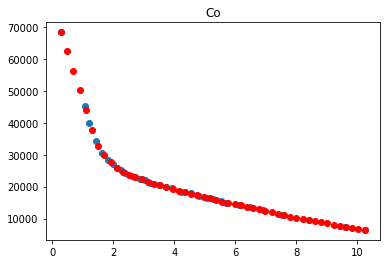

In [20]:
x, ysp, y = decumulate_measured_spectrum(raw_data_Co, 'linear')
plt.title('Co')

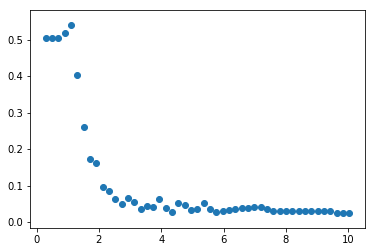

In [21]:
#%matplotlib notebook
plt.scatter(x, y)

plt.plot(x, y)

Text(0.5,1,u'Cs')

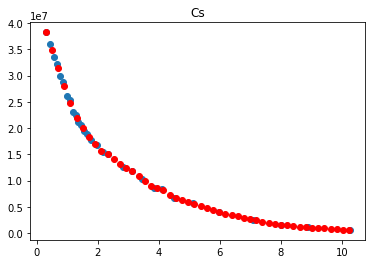

In [22]:
raw_data_Cs = pd.read_excel('Threshold_calib_Cs.xlsx')
x_Cs, ysp_Cs, y_Cs = decumulate_measured_spectrum(raw_data_Cs, 'linear')
plt.title('Cs')

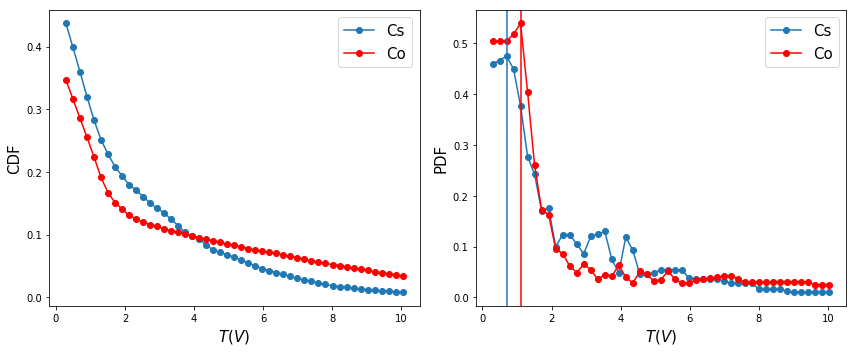

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(x_Cs, ysp_Cs, 'o-', label = 'Cs')
ax[0].plot(x, ysp, 'or-', label = 'Co')
ax[1].plot(x_Cs, y_Cs, 'o-', label = 'Cs')
ax[1].plot(x, y, 'or-', label = 'Co')
th_Co, = x[y==max(y)]
ax[1].axvline(th_Co, c = 'r')
th_Cs, = x_Cs[y_Cs==max(y_Cs)]
ax[1].axvline(th_Cs, c = 'C0')

[a.set_xlabel('$T (V)$', fontsize =15) for a in ax]
ax[0].set_ylabel('CDF', fontsize=15)
ax[1].set_ylabel('PDF', fontsize=15)

[a.legend(fontsize = 15) for a in ax]
plt.tight_layout()
plt.gcf()
plt.savefig('th_calibration.png', dpi = 300)

[0.47765013623978203, 0.9602946334619431]
[0.6961224489795919, 1.1022448979591837]


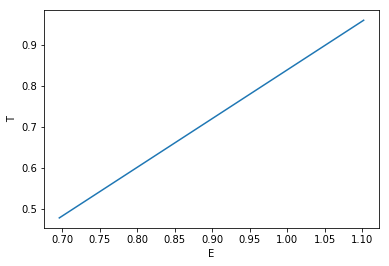

In [24]:
energies = [gamma_Cs[1], gamma_Co[0]]
print energies
threshold = [th_Cs, th_Co]
print threshold
plt.plot(threshold, energies)
plt.xlabel('E')
plt.ylabel('T')
slope, intercept, r_value, p_value, std_err = stats.linregress(energies, threshold)

In [25]:
print slope*4.5+intercept

4.080739049241165


In [26]:
slope, intercept, r_value, p_value, std_err = stats.linregress(threshold, energies)

In [27]:
print slope*4.5+intercept

4.998258570271873


# Wrong measurements

In [28]:
#dt_23 = np.loadtxt('Muons2018/shift-2-3.txt', delimiter = ';', skiprows = 5)
dt_23 = np.loadtxt('Muons2018/C1H00000--00000.txt', delimiter = ';', skiprows = 5)


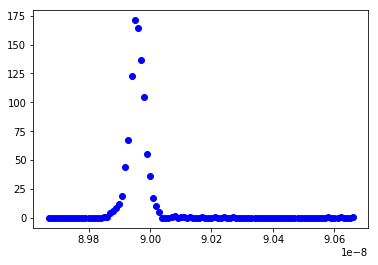

In [29]:
plt.plot(dt_23[:,0], dt_23[:,1], 'ob')
#plt.xlim(8.98e-8, 9.01e-8)

# N-th "good" measurement $N\rightarrow\infty$

In [30]:
#Background estimation
data_stop = np.loadtxt('Muons2018/muon1wBTOP--00001.txt',  delimiter = ';', skiprows = 5, dtype=float)
data_sbottom = np.loadtxt('Muons2018/muon1wBBOTTOM--00001.txt' , delimiter = ';', skiprows = 5, dtype=float)

(0, 2000)

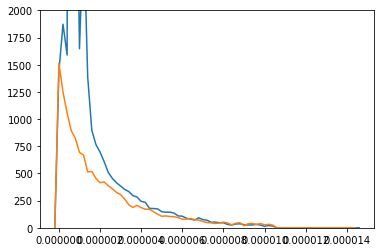

In [31]:
x_top = data_stop[:,0]
y_top = data_stop[:,1]
x_bottom = data_sbottom[:,0]
y_bottom = data_sbottom[:,1]
plt.plot(x_top, y_top)
plt.plot(x_bottom, y_bottom)
plt.ylim(0,2000)

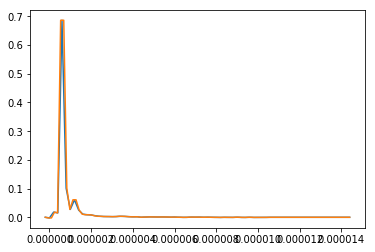

In [32]:
bkg_y = (y_top[:-1]-y_bottom)
bkg_y /=sum(bkg_y)
plt.plot(x_bottom, bkg_y)
bkg_interpF = interpolate.interp1d(x_bottom, bkg_y, kind='nearest')
t = np.linspace(x_bottom[0], x_bottom[-1], 100)
plt.plot(t, bkg_interpF(t))

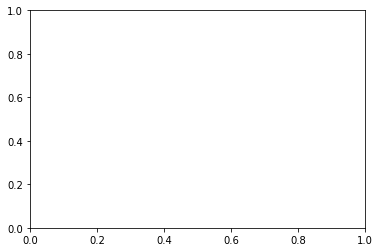

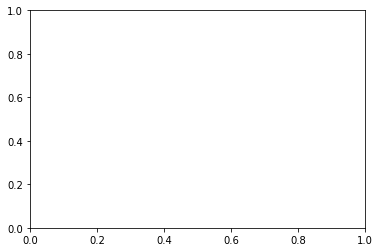

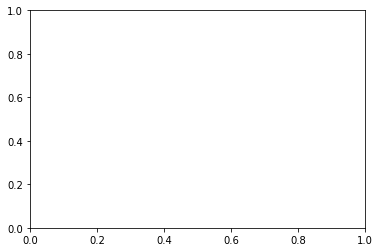

In [160]:
def f(x, a, t, b):
    return a *np.exp(x*t) + b

def removeBackgroundPeaks(bkg, data_x, data_y, n):
    for i in range(n):
        ind = np.where(bkg == max(bkg))
        data_x = np.delete(data_x, ind)
        data_y = np.delete(data_y, ind)
        bkg = np.delete(bkg, ind)
    return data_x, data_y

def chisq(data, fit, params):
    deg = len(data)-params
    return sum((data-fit)**2/fit)/deg
def doTheFit(data, th=0, f =f, guess = [500., -(2.2e-6)**-1,1], ax=plt.figure().gca(), removeBkg = 5):
    th+=2
    y =data[:,1]
    sy = sum(y[th+2:])
    x= data[th:,0]
    scale =1.
    bkg = sy*bkg_interpF(x)/scale
    y =(data[th:,1])/scale#  - bkg
    dummy_y = np.copy(y)
    y=y[abs(dummy_y)!=0]
    x=x[abs(dummy_y)!=0]
    #ax.plot(x, bkg, 'ok')
    x, y = removeBackgroundPeaks(bkg, x, y, removeBkg)
    print 'The number of counts is %i'%(sum(y*scale))
    popt, pcov = curve_fit(f, x, y, guess)
    perr = np.sqrt(np.diag(pcov))
    print 'Parameters: ', popt
    t = np.linspace(x[0], x[-1], 100)
    print 'The muon lifetime obtained is %.3f mus'%(-popt[1]**-1 * 1e6)
    print 'The background level is estimated to be %.2f of the total'%popt[-1]
    ax.plot(x,y, 'ob')
    ax.plot(t, f(t, *popt), label = '$t>%.2f\mu s\ \ \\tau = %.3f\mu s$'%(x[0]*1e6, -popt[1]**-1 * 1e6), lw = 5)
    #ax.plot(t, popt[0]*np.exp(-t/(2.2e-6))+popt[-1])
    #ax.plot(t, popt[0]*np.exp(-t/(0.15e-6))+popt[-1])
    print 'The errors in the fit are ', perr
    print 'Chi sq = %.3f'%chisq(y, f(x, *popt), len(guess))

    return -popt[1]**-1 * 1e6
    
def doTheDoubleFit(data, th=0, f =f, guess = [500.,500., -(2.2e-6)**-1, -(0.16e-6)**-1,20], ax=plt.figure().gca(), removeBkg=5):
    def f(x, a,c, tp, tm, b):
        return a*np.exp(x*tp) + c*np.exp(x*tm) + b
    th+=2
    y =data[:,1]
    sy = sum(y[th:])
    x= data[th:,0]
    #print x
    scale =1.
    bkg = sy*bkg_interpF(x)/scale
    y =(data[th:,1])/scale#  - bkg
    dummy_y = np.copy(y)
    y=y[abs(dummy_y)!=0]
    x=x[abs(dummy_y)!=0]
    x, y = removeBackgroundPeaks(bkg, x, y, removeBkg)
    print 'The number of counts is %i'%(sum(y*scale))
    popt, pcov = curve_fit(f, x, y, guess, bounds=([0, 0, -np.inf, -np.inf, 0], [np.inf,np.inf, 0, 0, np.inf]))
    print pcov
    print 'Parameters: ', popt
    t = np.linspace(x[0], x[-1], 100)
    print 'The positive muon lifetime obtained is %.3f mus'%(-popt[2]**-1 * 1e6)
    print 'The negative muon lifetime obtained is %.3f mus'%(-popt[3]**-1 * 1e6)

    print 'The background level is estimated to be %.2f of the total'%popt[-1]
    ax.plot(x,y, 'ob')
    #ax.plot(x, bkg, 'ok')
    ax.plot(t, f(t, *popt), label = '$t>%.2f\mu s\ \ \\tau^+ = %.3f\mu s\ \ \\tau^- = %.3f\mu s$'%(x[0]*1e6, -popt[2]**-1 * 1e6, -popt[3]**-1 * 1e6, ), lw = 5)
    #ax.plot(t, popt[0]*np.exp(-t/(2.2e-6))+popt[-1])
    #ax.plot(t, popt[0]*np.exp(-t/(0.15e-6))+popt[-1])
    perr = np.sqrt(np.diag(pcov))
    print 'The errors in the fit are ', perr
    print 'Chi sq = %.3f'%chisq(y, f(x, *popt), len(guess))

def doTheLinearFit(data, th=0,ax=plt.figure().gca()):
    '''
    y =data[:,1]
    x= data[th:,0]
    #print x
    scale =1e3
    y =data[th:,1]/scale
    '''
    th+=2
    y =data[:,1]
    sy = sum(y[th:])
    x= data[th:,0]
    #print x
    scale =1e3
    bkg = sy*bkg_interpF(x)/scale
    y =(data[th:,1])/scale#  - bkg
    x, y = removeBackgroundPeaks(bkg, x, y, 5)
    print 'The total number of counts is %i'%(sum(y*scale))
    y = np.log(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    t = np.linspace(x[0], x[-1], 100)
    print 'The muon lifetime obtained is %.3f mus'%(-slope**-1 * 1e6)
    #print 'The background level is estimated to be %.2f of the total'%popt[-1]
    ax.plot(x,y, 'ob')
    ax.plot(t, t*slope + intercept, label = '$t>%.2f\mu s\ \ \\tau = %.3f\mu s$'%(x[0]*1e6, -slope**-1 * 1e6), lw = 5)
    print 'R^2 = %.2f'%(r_value**2)
    #ax.plot(t, popt[0]*np.exp(-t/(2.2e-6))+popt[-1])
    #ax.plot(t, popt[0]*np.exp(-t/(0.15e-6))+popt[-1])


# Linearized Data Fit

-4e-07 2.12e-22
The total number of counts is 20697
The muon lifetime obtained is 2.424 mus
R^2 = 0.98
The total number of counts is 3362
The muon lifetime obtained is 2.877 mus
R^2 = 0.93


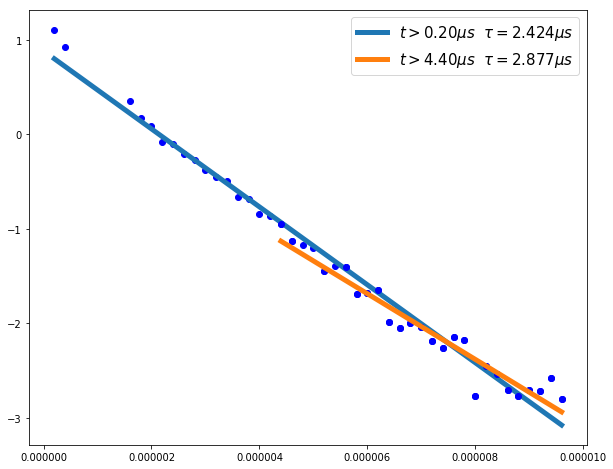

In [161]:
data2weekOK = np.loadtxt('Muons2018/muon2weekOK--00000.txt', delimiter = ';', skiprows = 5, dtype=float)
fig, ax = plt.subplots(1,1, figsize=(10,8))
print data2weekOK[:,0][0], x_bottom[0]
doTheLinearFit(data2weekOK,1, ax=ax)
doTheLinearFit(data2weekOK,20, ax=ax)
plt.legend(loc=0, fontsize=15)


# Single exponential fit

## Original Top + Bottom data

The number of counts is 20697
Parameters:  [ 3.18652039e+03 -5.46205913e+05  5.98884565e+01]
The muon lifetime obtained is 1.831 mus
The background level is estimated to be 59.89 of the total
The errors in the fit are  [  34.24425496 9887.46462398   10.50456604]
Chi sq = 2.703
The number of counts is 8484
Parameters:  [ 2.67969060e+03 -4.62869245e+05  2.27550004e+01]
The muon lifetime obtained is 2.160 mus
The background level is estimated to be 22.76 of the total
The errors in the fit are  [1.10134534e+02 1.56381842e+04 8.06021034e+00]
Chi sq = 1.381


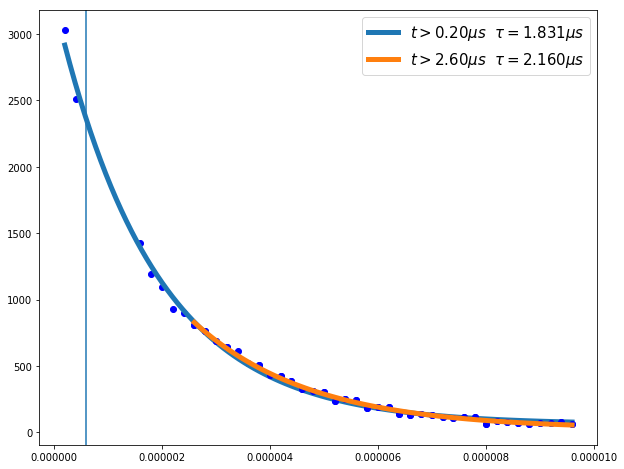

In [162]:
data2weekOK = np.loadtxt('Muons2018/muon2weekOK--00000.txt', delimiter = ';', skiprows = 5)
fig, ax = plt.subplots(1,1, figsize=(10,8))

tau_total = doTheFit(data2weekOK,1, ax=ax)
tau_plus = doTheFit(data2weekOK,10, ax=ax)
#tau_minus = ((1./tau_total) - (1./tau_plus))**-1
#print 'The NEGATIVE MUON lifetime obtained is %.3f mu s'%tau_minus
x= np.linspace(1e-7, 10e-6, 1000)

#ax.plot(x,5.10259278e+03*np.exp(-x/(2.2e-6)), label = '$\\tau = 2.2 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x/(0.15e-6)), label = '$\\tau = 0.15 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x*((2.2e-6)**-1 + (0.15e-6)**-1)), label = '$\\tau = total \mu s$', lw=5)
ax.axvline(6e-07)
plt.legend(loc=0, fontsize=15)

## Just Bottom data

The number of counts is 5459
Parameters:  [ 5.66044386e+02 -4.97974947e+05  1.35761838e+01]
The muon lifetime obtained is 2.008 mus
The background level is estimated to be 13.58 of the total
The errors in the fit are  [8.85278521e+00 1.38313530e+04 2.65240003e+00]
Chi sq = 0.784
The number of counts is 2517
Parameters:  [ 5.17609114e+02 -4.50363496e+05  8.93557311e+00]
The muon lifetime obtained is 2.220 mus
The background level is estimated to be 8.94 of the total
The errors in the fit are  [2.57682600e+01 2.03118409e+04 2.26288098e+00]
Chi sq = 0.574


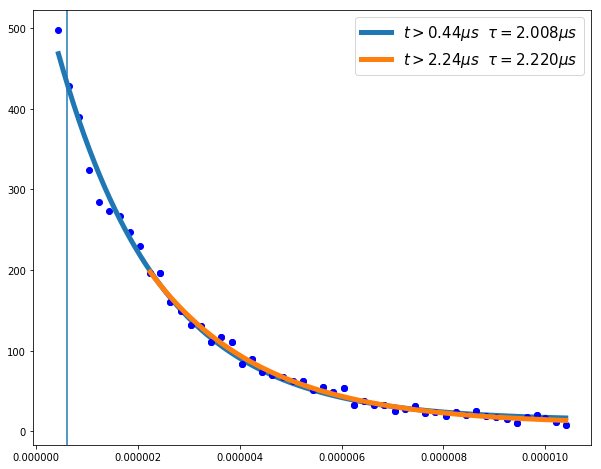

In [163]:
data2weekOK = np.loadtxt('Muons2018/muon1wBOTTOMnoB--00000.txt', delimiter = ';', skiprows = 5)

fig, ax = plt.subplots(1,1, figsize=(10,8))

tau_total = doTheFit(data2weekOK,1, ax=ax, removeBkg=0)
tau_plus = doTheFit(data2weekOK,10, ax=ax, removeBkg=0)
#tau_minus = ((1./tau_total) - (1./tau_plus))**-1
#print 'The NEGATIVE MUON lifetime obtained is %.3f mu s'%tau_minus
x= np.linspace(1e-7, 10e-6, 1000)

#ax.plot(x,5.10259278e+03*np.exp(-x/(2.2e-6)), label = '$\\tau = 2.2 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x/(0.15e-6)), label = '$\\tau = 0.15 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x*((2.2e-6)**-1 + (0.15e-6)**-1)), label = '$\\tau = total \mu s$', lw=5)
ax.axvline(6e-07)
plt.legend(loc=0, fontsize=15)

# Double exponential fit

## Original Top + Bottom data

The number of counts is 20697
[[ 6.27805241e+03  9.67158464e+03 -1.06151624e+06 -1.06773936e+08
   4.71760421e+02]
 [ 9.67158464e+03  9.80314255e+04 -1.55971934e+06 -4.44970296e+08
   6.95619613e+02]
 [-1.06151624e+06 -1.55971934e+06  2.15921767e+08  1.80320050e+10
  -1.21208235e+05]
 [-1.06773936e+08 -4.44970296e+08  1.80320050e+10  2.83432414e+12
  -8.40604779e+06]
 [ 4.71760421e+02  6.95619613e+02 -1.21208235e+05 -8.40604779e+06
   9.82370822e+01]]
Parameters:  [ 2.85530523e+03  1.26429680e+03 -4.89398636e+05 -5.63738436e+06
  3.43264924e+01]
The positive muon lifetime obtained is 2.043 mus
The negative muon lifetime obtained is 0.177 mus
The background level is estimated to be 34.33 of the total
The errors in the fit are  [7.92341619e+01 3.13099705e+02 1.46942767e+04 1.68354511e+06
 9.91146216e+00]
Chi sq = 1.498
The number of counts is 3362
Parameters:  [ 3.50721186e+03 -5.35089261e+05  4.03603234e+01]
The muon lifetime obtained is 1.869 mus
The background level is estimated to be

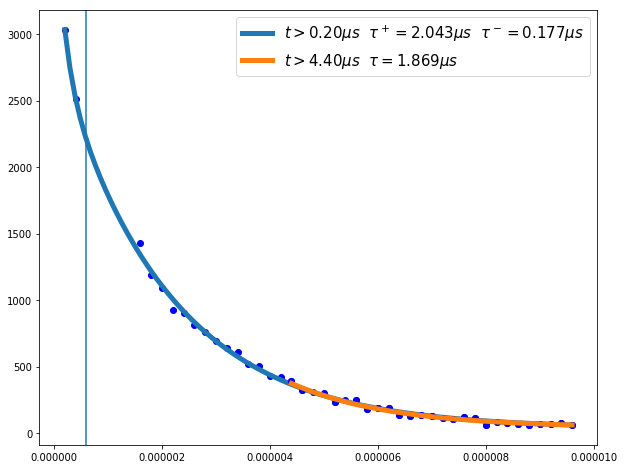

In [164]:
data2weekOK = np.loadtxt('Muons2018/muon2weekOK--00000.txt', delimiter = ';', skiprows = 5)
fig, ax = plt.subplots(1,1, figsize=(10,8))

tau_total = doTheDoubleFit(data2weekOK,1, ax=ax)
tau_plus = doTheFit(data2weekOK,20, ax=ax)
#tau_minus = ((1./tau_total) - (1./tau_plus))**-1
#print 'The NEGATIVE MUON lifetime obtained is %.3f mu s'%tau_minus
x= np.linspace(1e-7, 10e-6, 1000)

#ax.plot(x,5.10259278e+03*np.exp(-x/(2.2e-6)), label = '$\\tau = 2.2 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x/(0.15e-6)), label = '$\\tau = 0.15 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x*((2.2e-6)**-1 + (0.15e-6)**-1)), label = '$\\tau = total \mu s$', lw=5)
ax.axvline(6e-07)
plt.legend(loc=0, fontsize=15)

## Just Bottom data

The number of counts is 5459
[[ 3.29800896e+02  2.12488906e+03 -3.03560721e+05 -1.96135852e+07
   2.88771115e+01]
 [ 2.12488906e+03  3.59542141e+04 -1.68911582e+06 -2.37906330e+08
   1.51844943e+02]
 [-3.03560721e+05 -1.68911582e+06  3.51733962e+08  1.66733990e+10
  -4.36726546e+04]
 [-1.96135852e+07 -2.37906330e+08  1.66733990e+10  1.75792219e+12
  -1.59100880e+06]
 [ 2.88771115e+01  1.51844943e+02 -4.36726546e+04 -1.59100880e+06
   7.78674251e+00]]
Parameters:  [ 5.07474615e+02  3.84025453e+02 -4.38042686e+05 -3.74762768e+06
  7.57936390e+00]
The positive muon lifetime obtained is 2.283 mus
The negative muon lifetime obtained is 0.267 mus
The background level is estimated to be 7.58 of the total
The errors in the fit are  [1.81604211e+01 1.89615965e+02 1.87545718e+04 1.32586658e+06
 2.79047353e+00]
Chi sq = 0.598
The number of counts is 1130
Parameters:  [ 4.75766366e+02 -4.26331283e+05  7.41166233e+00]
The muon lifetime obtained is 2.346 mus
The background level is estimated to be 7

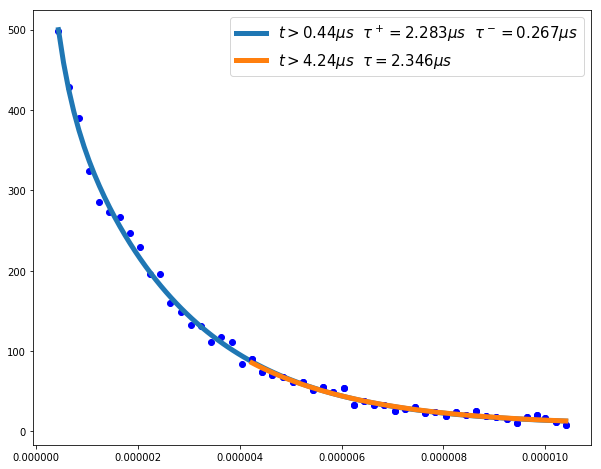

In [188]:
data2weekOK = np.loadtxt('Muons2018/muon1wBOTTOMnoB--00000.txt', delimiter = ';', skiprows = 5)
fig, ax = plt.subplots(1,1, figsize=(10,8))

tau_total = doTheDoubleFit(data2weekOK,1, ax=ax, removeBkg=0)
tau_plus = doTheFit(data2weekOK,20, ax=ax, removeBkg=0)
#tau_minus = ((1./tau_total) - (1./tau_plus))**-1
#print 'The NEGATIVE MUON lifetime obtained is %.3f mu s'%tau_minus
x= np.linspace(1e-7, 10e-6, 1000)

#ax.plot(x,5.10259278e+03*np.exp(-x/(2.2e-6)), label = '$\\tau = 2.2 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x/(0.15e-6)), label = '$\\tau = 0.15 \mu s$', lw=5)
#ax.plot(x,5.10259278e+03*np.exp(-x*((2.2e-6)**-1 + (0.15e-6)**-1)), label = '$\\tau = total \mu s$', lw=5)
#ax.axvline(6e-07)
plt.legend(loc=0, fontsize=15)

In [166]:
w = 57.5 #m 0.5cm


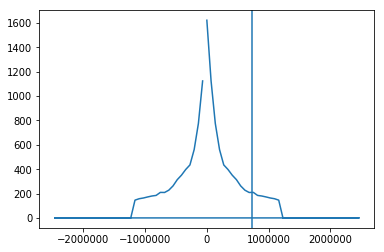

In [167]:
#%matplotlib notebook
%matplotlib inline
x_top = data_stop[1:-1,0]
y_top = data_stop[1:-1,1]
x_bottom = data_sbottom[1:,0]
y_bottom = data_sbottom[1:,1]
top_fft = np.fft.fft(y_top, norm='ortho')
top_freq = np.fft.fftfreq(len(x_top), d = x_top[2]-x_top[1])
bottom_fft = np.fft.fft(y_bottom, norm='ortho')
bottom_freq = np.fft.fftfreq(len(x_bottom), d = x_bottom[2]-x_bottom[1])
filter_mask = (abs(bottom_freq)>=1.2e6)
bottom_fft[filter_mask]=1e-10
plt.plot(bottom_freq,abs(bottom_fft))
plt.axvline(4611392.284/(2*np.pi))


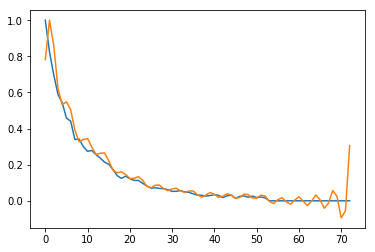

In [168]:
reconstructed = np.fft.ifft(bottom_fft)
plt.plot(y_bottom/max(y_bottom))
plt.plot(reconstructed/max(reconstructed))

In [169]:
fmax = 1.29062e6
wmax = fmax*2*np.pi
print 'The g obtained is %.3f'%(wmax*2*(206.8*m_e)/(e*4e-3))

The g obtained is 4.767


# Fit data for $g$-factor

The number of counts is 13868
[[ 5.54875787e+02 -1.76578183e+06 -2.90093360e-03  3.98838766e+00
  -7.20219084e+01]
 [-1.76578183e+06  1.46836923e+10 -4.04240892e+02 -2.20352489e+04
   1.40673268e+05]
 [-2.90093360e-03 -4.04240892e+02  2.02701609e-04  7.23565562e-04
   7.32933731e-03]
 [ 3.98838766e+00 -2.20352489e+04  7.23565562e-04  4.61305644e-02
  -3.52241006e-01]
 [-7.20219084e+01  1.40673268e+05  7.32933731e-03 -3.52241006e-01
   2.37536358e+01]]
Parameters:  [1.24253718e+03 1.83838969e+06 1.46665498e-01 4.39330886e-01
 1.55399033e+01]
The Larmor frequency obtained is 1838389.685 rad/s
The g obtained is 1.081
The background level is estimated to be 15.54 of the total
Chi sq = 2.705
The errors in the fit are  [2.35558016e+01 1.21176286e+05 1.42373315e-02 2.14780270e-01
 4.87377018e+00]


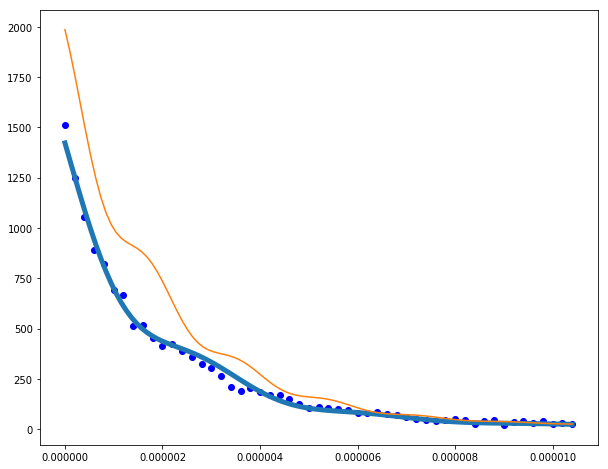

In [187]:
data_stop = np.loadtxt('Muons2018/muon1wBTOP--00001.txt',  delimiter = ';', skiprows = 5, dtype=float)
data_sbottom = np.loadtxt('Muons2018/muon1wBBOTTOM--00001.txt' , delimiter = ';', skiprows = 5, dtype=float)
data = np.copy(data_sbottom)
fig, ax = plt.subplots(1,1, figsize = (10,8))
guess = [500.,3e6, 1./3, 1., 3.]
def f(x, a, w, d, e,b):
        return a*np.exp(x*(-2.008e-6)**-1)*(1+d*np.cos(w*x+e)) + b
'''
guess = [100., -(2.2e-6)**-1, 1.]    
def f(x, a, t, b):
    return a*np.exp(x*t) + b
'''
th=1
y =data[:,1]
sy = sum(y[th+2:])
x= data[th:-20,0]

#print x
scale =1.
bkg = sy*bkg_interpF(x)/scale
y =(data[th:-20,1])/scale # - bkg
x, y = removeBackgroundPeaks(bkg, x, y, 0)
print 'The number of counts is %i'%(sum(y*scale))
popt, pcov = curve_fit(f, x, y, guess, method='dogbox', bounds=([0, 0, 0,-np.inf, 0], [np.inf, np.inf, 1.,np.inf, np.inf]))
print pcov
print 'Parameters: ', popt
t = np.linspace(x[0], x[-1], 100)
#print 'The muon lifetime obtained is %.3f mus'%(-popt[1]**-1 * 1e6)
print 'The Larmor frequency obtained is %.3f rad/s'%(popt[1])
print 'The g obtained is %.3f'%(abs(popt[1])*2*(206.8*m_e)/(e*4e-3))
print 'The background level is estimated to be %.2f of the total'%popt[-1]
ax.plot(x,y, 'ob')
#ax.plot(x, bkg, 'ok')
print 'Chi sq = %.3f'%chisq(y, f(x, *popt), len(guess))
ax.plot(t, f(t, *popt), label = '$t>%.2f\mu s\ \ \\tau = %.3f\mu s$'%(x[0]*1e6, -popt[1]**-1 * 1e6), lw = 5)
ax.plot(t, popt[0]*np.exp(-t/(2.008e-6))*(1+popt[2]*np.cos(3.4e6*t)+popt[-2])+popt[-1])
#ax.plot(t, popt[0]*np.exp(-t/(0.15e-6))+popt[-1])
perr = np.sqrt(np.diag(pcov))
print 'The errors in the fit are ', perr

The number of counts is 6771


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

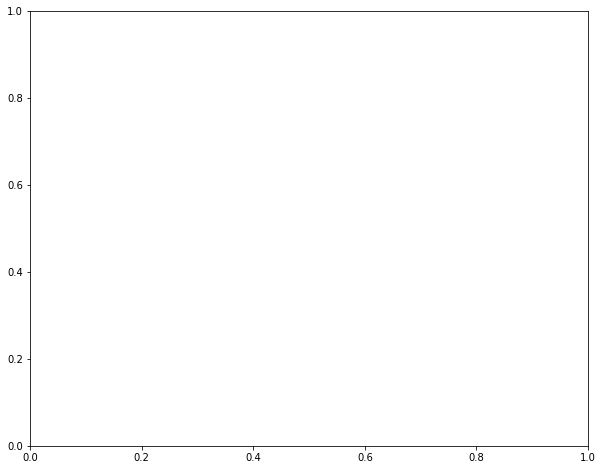

In [175]:
data_stop = np.loadtxt('Muons2018/muon1wBTOP--00001.txt',  delimiter = ';', skiprows = 5, dtype=float)
data_sbottom = np.loadtxt('Muons2018/muon1wBOTTOMnoB--00000.txt' , delimiter = ';', skiprows = 5, dtype=float)
data = np.copy(data_sbottom)
fig, ax = plt.subplots(1,1, figsize = (10,8))
guess = [500., -(2.2e-6)**-1,3.4e6, 1., 1./3, 1.]
def f(x, a, t, w, b, d, e):
        return a*np.exp(x*t)*(1+d*np.cos(w*x+e)) + b
'''
guess = [100., -(2.2e-6)**-1, 1.]    
def f(x, a, t, b):
    return a*np.exp(x*t) + b
'''
th=1
y =data[:,1]
sy = sum(y[th+2:])
x= data[th:-20,0]
#print x
scale =1.
bkg = sy*bkg_interpF(x)/scale
y =(data[th:-20,1])/scale # - bkg
x, y = removeBackgroundPeaks(bkg, x, y, 0)
print 'The number of counts is %i'%(sum(y*scale))
popt, pcov = curve_fit(f, x, y, guess, method='lm')
print pcov
print 'Parameters: ', popt
t = np.linspace(x[0], x[-1], 100)
print 'The muon lifetime obtained is %.3f mus'%(-popt[1]**-1 * 1e6)
print 'The Larmor frequency obtained is %.3f rad/s'%(popt[2])
print 'The g obtained is %.3f'%(abs(popt[2])*2*(200*m_e)/(e*4e-3))
print 'The background level is estimated to be %.2f of the total'%popt[-1]
ax.plot(x,y, 'ob')
#ax.plot(x, bkg, 'ok')
ax.plot(t, f(t, *popt), label = '$t>%.2f\mu s\ \ \\tau = %.3f\mu s$'%(x[0]*1e6, -popt[1]**-1 * 1e6), lw = 5)
#ax.plot(t, popt[0]*np.exp(-t/(2.2e-6))+popt[-1])
#ax.plot(t, popt[0]*np.exp(-t/(0.15e-6))+popt[-1])
perr = np.sqrt(np.diag(pcov))
print 'The errors in the fit are ', perr
print 'Chi sq = %.3f'%chisq(y, f(x, *popt), len(guess))
plt.legend()

th = 5 #3 in the minimum, 5 is best
div = 3
data2weekOK = np.loadtxt('Muons2018/muon2weekOK--00000.txt', delimiter = ';', skiprows = 5)
fig, ax = plt.subplots(1,1, figsize=(10,8))
x = data2weekOK[th:,0]
y = data2weekOK[th:,1]
sy = sum(y)
bkg = sy*bkg_interpF(x)
y =data[th:,1]
x, y = removeBackgroundPeaks(bkg, x, y, 5)
y=np.log(y)
ax.plot(x, y, 'or')
'''
x1 = x[:div]
y1 = y[:div]
ax.plot(x1, y1, 'ob')
t = np.linspace(x1[0], x1[-1], 100)
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1, y1)
def line(coord,slope, intercept):
    return coord*slope + intercept
ax.plot(t, line(t, slope1, intercept1), c='b', label = '$\\tau = %.3f;\ r^2 = %.2f$'%(-slope1**-1 * 1e6, r_value1**2))

x2 = x[div:]
y2 = y[div:]
t = np.linspace(x2[0], x2[-1], 100)
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2, y2)
ax.plot(t, line(t, slope2, intercept2), c='r', label = '$\\tau = %.3f;\ r^2 = %.2f$'%(-slope2**-1 * 1e6, r_value2**2))
'''
plt.legend(fontsize=15)